# Neural Computing Coursework - Multilayer Perceptron

Multilayer perceptrons are neural networks. Neural networks serve as function approximators. A function defines a relationship between two or more entities. In the typical pattern recognition (or supervised learning) paradigm, the relationships of interest are those between a set of input (independent/feature) variables and output (target/dependent) variables. These relationships are then codified to generalise to previously unseen data. 

The mechanisms behind neural nets are loosely motivated from neurobiological processes, where the firing of a neuron sets off (or "activates") neurons in its neighbouring vicinity, initiating a chain reaction of fired neurons throughout the brain (or "network"). This idea highlights the power of these models. This power comes not from the neurons themselves, but from the interconnections between them. These interconnections are represented as "weights", and the thresholds for activation by "biases".

The goal of the network then becomes to employ optimization techniques borrowed from numerical analysis, which alter these weights and biases in order to minimise a specified loss function.

The structure of this notebook will be as follows:

1.   Problem Definition + Motivation
2.   Import Dataset + Basic EDA + Data Preparation
3.   Construction of base model + Evaluation
4.   Adaptation of base model network architecture + Evaluation
5.   Adaptation of hyperparameters + Evaluation
6.   Hyperparameter tuning using Grid Search + Evaluation
7.   Optimal model construction using grid search results + Evaluation

**1. Problem Definition and Motivation**

The problem is to classify handwritten digits with values ranging from 0-9. Handwritten digit recognition is a classic problem investigated in neural network experiments. It serves as a good benchmark for implementing other shape recognition algorithms. 

**2. Import Dataset + Basic EDA + Data Preparation**

The dataset used for this task was obtained from Kaggle - where it was collected from the MNIST handwritten digit database and converted to a csv format. The handwritten digits come from approximately 250 writers. The training and test sets consist of 60000 and 10000 images, respectively, with the writers in each dataset being disjoint.

Each row in the training and test sets correspond to a single image. The first column contains the labels for each image (0-9). The remaining columns of the dataset represent the pixel values for each of the 784 pixels within the 28x28 images. These values range from 0-255, where 0 and 255 correspond to black and white pixels, respectively.

**2. i) Loading Drive and Importing Libaries**

Note: The libraries imported here are not just for dataset loading, but also for model training and evaluation required in the later sections.

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
sklearn.__version__

NameError: name 'sklearn' is not defined

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
import pickle
import os

In [ ]:
pip install skorch

     |████████████████████████████████| 155 kB 13.2 MB/s 


In [ ]:
from skorch import NeuralNetClassifier

In [ ]:
# Change directory to current directory
os.chdir("drive/My Drive/Neural Computing")

**2. ii) Loading data**

In [ ]:
mnist_train = pd.read_csv("Data/mnist_train.csv")
mnist_test = pd.read_csv("Data/mnist_test.csv")

In [ ]:
mnist_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
mnist_test.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**2 iii) Exploratory Data Analysis (EDA)**

In [ ]:
print(mnist_train.shape)
print(mnist_test.shape)

(60000, 785)
(10000, 785)


In [ ]:
# Checking for missing values
print(mnist_train.isnull().sum().sum())
print(mnist_train.isnull().sum().sum())

0
0


In [ ]:
# Checking data types
print(mnist_train.dtypes.unique())
print(mnist_test.dtypes.unique())

[dtype('int64')]
[dtype('int64')]


Results above show that all entries are integers. Pixel values will need to be converted to floats for compatability in the next sections.

In [ ]:
# Outlier detection - Given that pixel values range between 0 and 255, we check to see if there are any values lying outside this range
# Ordinarily, data visualisation serves as a great tool for outlier detection. However, the size of the dataset makes this infeasible.
# Instead, we use an alternative approach
train_outlier_high = mnist_train[mnist_train > 255].sum().sum()
train_outlier_low =  mnist_train[mnist_train < 0].sum().sum()
print("Number of outliers in training dataset: ", train_outlier_high+train_outlier_low)

Number of outliers in training dataset:  0.0


In [ ]:
test_outlier_high = mnist_test[mnist_test > 255].sum().sum()
test_outlier_low =  mnist_test[mnist_test < 0].sum().sum()
print("Number of outliers in test dataset: ", test_outlier_high+test_outlier_low)

Number of outliers in test dataset:  0.0


In [ ]:
# Analysis of target variables - for training and test sets
# Training set
mnist_train["label"].value_counts().sort_index()/mnist_train.shape[0]

0    0.098717
1    0.112367
2    0.099300
3    0.102183
4    0.097367
5    0.090350
6    0.098633
7    0.104417
8    0.097517
9    0.099150
Name: label, dtype: float64

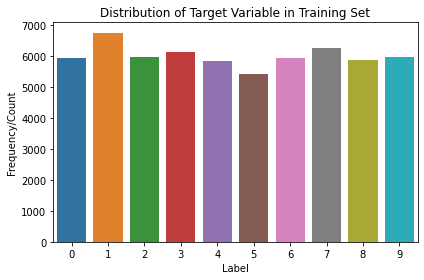

In [ ]:
# Plotting distribution of dependent variables in training set
sns.countplot(data = mnist_train, x = "label")
plt.title("Distribution of Target Variable in Training Set")
plt.xlabel("Label")
plt.ylabel("Frequency/Count")
plt.tight_layout()
plt.show()

In [ ]:
# Test set
mnist_test["label"].value_counts().sort_index()/mnist_test.shape[0]

0    0.0980
1    0.1135
2    0.1032
3    0.1010
4    0.0982
5    0.0892
6    0.0958
7    0.1028
8    0.0974
9    0.1009
Name: label, dtype: float64

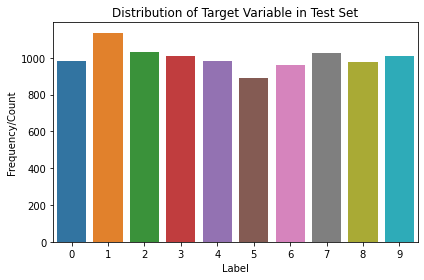

In [ ]:
# Plotting distribution of dependent variables in test set 
sns.countplot(data = mnist_test, x = "label")
plt.title("Distribution of Target Variable in Test Set")
plt.xlabel("Label")
plt.ylabel("Frequency/Count")
plt.tight_layout()
plt.show()

Results above show that the data is balanced, invalidating the need for oversampling/undersampling techniques utilised for imbalanced data.

**2. iv) Data Preparation**



Before splitting the data into independent and dependent variables, it is important to create a validation set. Given the large size of the dataset, implementing cross-validation will be time consuming. Running this process on a validation set of a smaller size will overcome this constraint. To create the cross-validation set, 10% of the training set will be randomly sampled. It is important after sampling to check that the distribution of the target class is maintained.

Further data preparation will include the transformation of variable types to ensure compatability with the models built in the later sections.

In [ ]:
mnist_val = mnist_train.sample(frac=0.1)

In [ ]:
mnist_val.shape

(6000, 785)

In [ ]:
mnist_val["label"].value_counts().sort_index()/mnist_val.shape[0]

0    0.104833
1    0.109500
2    0.095167
3    0.102000
4    0.092500
5    0.095333
6    0.092500
7    0.109667
8    0.099000
9    0.099500
Name: label, dtype: float64

In [ ]:
# Splitting independent and dependent variabels for training, validation and test sets
y_train = mnist_train["label"]
y_test = mnist_test["label"]
y_val = mnist_val["label"]

In [ ]:
X_train = mnist_train.drop("label", axis = 1)
X_test = mnist_test.drop("label", axis = 1)
X_val = mnist_val.drop("label", axis = 1)

In [ ]:
# Changing datatypes of data for compatability with model building
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_val = X_val.astype("float32")

In [ ]:
y_train = y_train.astype("int64")
y_test = y_test.astype("int64")
y_val = y_val.astype("int64")

In [ ]:
# Scaling pixel values to improve convergence properties during training
X_train /= 255.0
X_test /= 255.0
X_val /= 255.0

In [ ]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_val = X_val.to_numpy()

In [ ]:
X_train = np.float32(X_train)
X_test = np.float32(X_test)
X_val = np.float32(X_val)
y_train = np.int64(y_train)
y_test = np.int64(y_test)
y_val = np.int64(y_val)

In [ ]:
X_train.shape, y_train.shape

((60000, 784), (60000,))

In [ ]:
X_val.shape, y_val.shape

((6000, 784), (6000,))

In [ ]:
X_test.shape, y_test.shape

((10000, 784), (10000,))

Now that the data has been scaled and prepared, it is useful to plot some sample images from the dataset.

In [ ]:
# To plot images, we utilise the "plot_example" function obtained from lab 5 of the Neural Computing module at City, University of London
def plot_example(X,y):
  for i, (img, y) in enumerate(zip(X[:5].reshape(5,28,28), y[:5])):
    plt.subplot(151+i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(y)

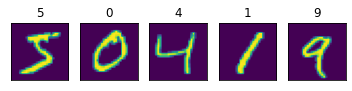

In [ ]:
plot_example(X_train, y_train)

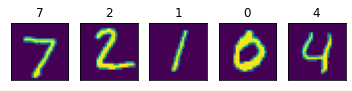

In [ ]:
plot_example(X_test, y_test)

**3.   Construction of base model + Evaluation**

To begin with, a base model will be constructed to serve as a benchmark for future iterations of model building.

The basic construction of a neural network requires the specification of three components:



*   Input dimensions - For the given task, the input dimensions are 784, corresponding to the pixel values for each pixel in the 28x28 image.
*   Output dimensions - Here, the output corresponds to digits from 0-9. There are 10 digits.


*   Hidden layers - Information required includes the number of hidden layers in addition to the number of neurons within them. For the base model, we start with just one hidden layer consisting of 50 neurons. 





In [ ]:
# Defining network architecture for base model using the PyTorch library
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.hidden = nn.Linear(784, 50)
    self.output = nn.Linear(50, 10)

  def forward(self, X, **kwargs):
    X = F.relu(self.hidden(X))
    X = F.softmax(self.output(X), dim=-1)
    return X

In [ ]:
# For the base run, we use the default values specified by skorch. For example, default values for learning rates and max epochs are 0.01 and 10 respectively
torch.manual_seed(10)

net = NeuralNetClassifier(
    Net
)

In [ ]:
net.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.8028       0.7727        1.2276  0.9760
      2        0.9235       0.8436        0.7098  0.9162
      3        0.6237       0.8656        0.5454  0.8753
      4        0.5114       0.8797        0.4685  0.9296
      5        0.4531       0.8878        0.4239  0.8969
      6        0.4172       0.8957        0.3948  0.9053
      7        0.3927       0.8995        0.3743  0.8633
      8        0.3748       0.9027        0.3590  0.9432
      9        0.3608       0.9052        0.3470  0.8742
     10        0.3495       0.9091        0.3373  0.9050


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (hidden): Linear(in_features=784, out_features=50, bias=True)
    (output): Linear(in_features=50, out_features=10, bias=True)
  ),
)

In [ ]:
# Making predictions on test set
y_pred = net.predict(X_test)

In [ ]:
# Calculating prediction accuracy
accuracy_score(y_test, y_pred)

0.9083

In [ ]:
# Calculating confusion matrix 
cf = confusion_matrix(y_test, y_pred)

In [ ]:
# Calculating how many times a digit was misclassified
num_misclassified_list = list()
for i in range(cf.shape[0]):
  num_classified = 0
  for j in range(cf.shape[1]):
    if i != j:
      num_classified += cf[i,j]
  num_misclassified_list.append(num_classified)

for i in range(len(num_misclassified_list)):
  print("The digit {} was misclassified {} times".format(i, num_misclassified_list[i]))

print("Total number of misclassified digits: {}".format(sum(num_misclassified_list)))

The digit 0 was misclassified 21 times
The digit 1 was misclassified 32 times
The digit 2 was misclassified 137 times
The digit 3 was misclassified 105 times
The digit 4 was misclassified 80 times
The digit 5 was misclassified 143 times
The digit 6 was misclassified 64 times
The digit 7 was misclassified 98 times
The digit 8 was misclassified 130 times
The digit 9 was misclassified 107 times
Total number of misclassified digits: 917


The results above show that the basic model performs poorly on the following digits: 2,3,5,8 and 9. This can be explained by the similarity in structure of the digits. For example, the top halves of the digits 2 and 3 are similarly structures. A similar argument holds for 8 and 9. 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


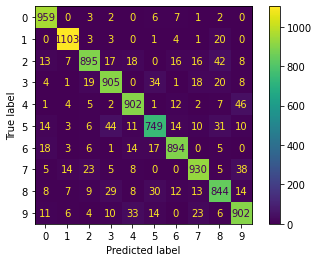

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(net, X_test, y_test)

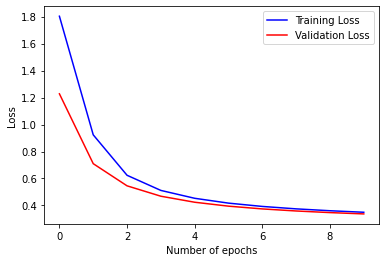

In [ ]:
# Plot loss curves
plt.plot(net.history[:,"train_loss"], label="Training Loss", color='b')
plt.plot(net.history[:,"valid_loss"], label="Validation Loss", color='r')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Observing misclassified images
misclassified_imgs = y_pred != y_test

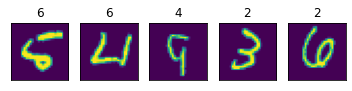

In [ ]:
plot_example(X_test[misclassified_imgs], y_pred[misclassified_imgs])

**4.   Adaptation of base model network architecture + Evaluation**

The next iteration to the base model will involve changing its network architecture. The initial model contained one hidden layer, consisting of 50 neurons. For the next iteration, an additional hidden layer will be added, and the number of neurons increased to 100, for each hidden layer.

In [ ]:
class Net2(nn.Module):
  def __init__(self):
    super(Net2, self).__init__()
    self.hidden1 = nn.Linear(784, 100)
    self.hidden2 = nn.Linear(100,100)
    self.output = nn.Linear(100, 10)

  def forward(self, X, **kwargs):
    X = F.relu(self.hidden1(X))
    X = F.relu(self.hidden2(X))
    X = F.softmax(self.output(X), dim=-1)
    return X

In [ ]:
# As in the first run, we use the default hyperparameter values specified by skorch. For example, default values for learning rates and max epochs are 0.01 and 10 respectively
torch.manual_seed(10)

net2 = NeuralNetClassifier(
    Net2
)

In [ ]:
net2.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2215       0.6508        2.0657  1.1026
      2        1.6205       0.7548        1.0989  1.0403
      3        0.8337       0.8360        0.6427  1.0912
      4        0.5649       0.8662        0.4955  1.0500
      5        0.4658       0.8810        0.4289  1.0691
      6        0.4157       0.8898        0.3911  1.0661
      7        0.3850       0.8970        0.3665  1.0560
      8        0.3637       0.9027        0.3489  1.0220
      9        0.3476       0.9067        0.3353  1.0656
     10        0.3346       0.9093        0.3241  1.0332


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net2(
    (hidden1): Linear(in_features=784, out_features=100, bias=True)
    (hidden2): Linear(in_features=100, out_features=100, bias=True)
    (output): Linear(in_features=100, out_features=10, bias=True)
  ),
)

In [ ]:
y_pred2 = net2.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred2)

0.9088

In [ ]:
cf2 = confusion_matrix(y_test, y_pred2)

In [ ]:
# Calculating how many times a digit was misclassified
num_misclassified_list = list()
for i in range(cf2.shape[0]):
  num_classified = 0
  for j in range(cf2.shape[1]):
    if i != j:
      num_classified += cf2[i,j]
  num_misclassified_list.append(num_classified)

for i in range(len(num_misclassified_list)):
  print("The digit {} was misclassified {} times".format(i, num_misclassified_list[i]))

print("Total number of misclassified digits: {}".format(sum(num_misclassified_list)))

The digit 0 was misclassified 21 times
The digit 1 was misclassified 29 times
The digit 2 was misclassified 129 times
The digit 3 was misclassified 121 times
The digit 4 was misclassified 80 times
The digit 5 was misclassified 125 times
The digit 6 was misclassified 65 times
The digit 7 was misclassified 102 times
The digit 8 was misclassified 143 times
The digit 9 was misclassified 97 times
Total number of misclassified digits: 912


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


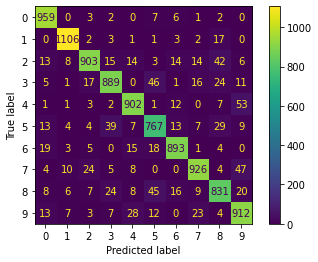

In [ ]:
plot_confusion_matrix(net2, X_test, y_test)

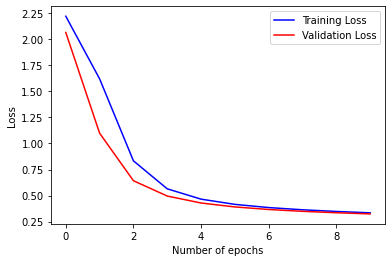

In [ ]:
plt.plot(net2.history[:,"train_loss"], label="Training Loss", color='b')
plt.plot(net2.history[:,"valid_loss"], label="Validation Loss", color='r')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Results show that the additional hidden layer and higher neurons do not improve model performance significantly. Model accuracy improves from 0.9083 to 0.9088, while the number of misclassified images reduces from 917 to 912. Therefore, the next iteration will revert back to the base model. This reversion includes reducing the number of hidden layers and neurons, which will save on computational time. 

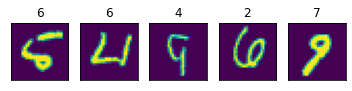

In [ ]:
# Observing misclassified images
misclassified_imgs = y_pred2 != y_test
plot_example(X_test[misclassified_imgs], y_pred2[misclassified_imgs])

**5.   Adaptation of hyperparameters + Evaluation**

The first iteration implemented was a base run. The second iteration involved altering the network architecture. So far, there have been no adaptations to the relevant hyperparameters neural nets. This will be done below.

The hyperparameters of interest are:

*   **max_epochs** - An epoch passes when the model has run through every example in the trianing set. The default value is 10. This will be increased to 20. Increasing the number of epochs increases the number of alterations made to the weights and biases of the network. Setting a value too high may lead to overfitting. 
*   **learning rate** - The learning rate controls the size of the updates made to the network parameters. Low learning rates may require a longer number of epochs as learning is slow. High learning rates may correspond to faster learning, but the network may converge to sub-optimal results. The default value for the learning rate is 0.01. This will be increased to 0.025.
*   **weight decay** - This parameter penalizes the loss function in order to reduce changes made during updates. It is used to prevent overfitting as well as prevent the gradient explosion problem.
*   **momentum** - A downside of neural networks is there convergence to local optima - given its large parameter space. Momentum helps the network "jump" out of these extremums in the error domain. 

The next section will utilise grid search to find the optimal values for each of the hyperparameters specified above.





In [ ]:
class Net3(nn.Module):
  def __init__(self):
    super(Net3, self).__init__()
    self.hidden = nn.Linear(784, 50)
    self.output = nn.Linear(50, 10)

  def forward(self, X, **kwargs):
    X = F.relu(self.hidden(X))
    X = F.softmax(self.output(X), dim=-1)
    return X

In [ ]:
# For the base run, we use the default values specified by skorch. For example, default values for learning rates and max epochs are 0.01 and 10 respectively
torch.manual_seed(10)

net3 = NeuralNetClassifier(
    Net3,
    lr = 0.025,
    max_epochs=20,
    optimizer__weight_decay=1e-2,
    optimizer__momentum=0.8,   
)

In [ ]:
net3.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6523       0.8982        0.3771  0.9376
      2        0.3668       0.9095        0.3437  0.8913
      3        0.3426       0.9135        0.3292  0.9392
      4        0.3282       0.9175        0.3173  0.9690
      5        0.3165       0.9205        0.3073  0.8952
      6        0.3078       0.9224        0.3001  0.9309
      7        0.3016       0.9231        0.2948  0.8870
      8        0.2971       0.9244        0.2909  1.0093
      9        0.2935       0.9247        0.2878  0.9016
     10        0.2907       0.9255        0.2854  0.9142
     11        0.2883       0.9267        0.2832  0.9137
     12        0.2864       0.9271        0.2816  0.9420
     13        0.2848       0.9279        0.2798  0.9044
     14        0.2835       0.9282        0.2787  0.9058
     15        0.2824       0.9286        0.2776  0.9311
     16        0.2814       0.9

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net3(
    (hidden): Linear(in_features=784, out_features=50, bias=True)
    (output): Linear(in_features=50, out_features=10, bias=True)
  ),
)

In [ ]:
y_pred3 = net3.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred3)

0.9339

In [ ]:
cf3 = confusion_matrix(y_test, y_pred3)

In [ ]:
# Calculating how many times a digit was misclassified
num_misclassified_list = list()
for i in range(cf3.shape[0]):
  num_classified = 0
  for j in range(cf3.shape[1]):
    if i != j:
      num_classified += cf3[i,j]
  num_misclassified_list.append(num_classified)

for i in range(len(num_misclassified_list)):
  print("The digit {} was misclassified {} times".format(i, num_misclassified_list[i]))

print("Total number of misclassified digits: {}".format(sum(num_misclassified_list)))

The digit 0 was misclassified 18 times
The digit 1 was misclassified 19 times
The digit 2 was misclassified 128 times
The digit 3 was misclassified 81 times
The digit 4 was misclassified 60 times
The digit 5 was misclassified 50 times
The digit 6 was misclassified 55 times
The digit 7 was misclassified 86 times
The digit 8 was misclassified 86 times
The digit 9 was misclassified 78 times
Total number of misclassified digits: 661


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


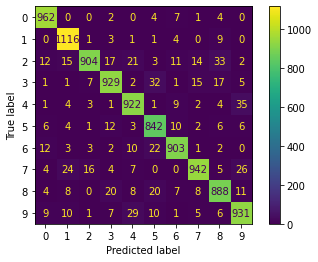

In [ ]:
plot_confusion_matrix(net3, X_test, y_test)

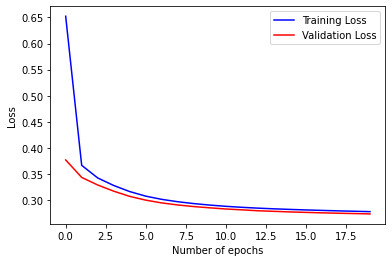

In [ ]:
plt.plot(net3.history[:,"train_loss"], label="Training Loss", color='b')
plt.plot(net3.history[:,"valid_loss"], label="Validation Loss", color='r')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

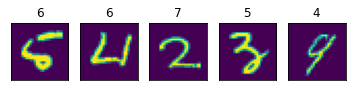

In [ ]:
# Observing misclassified images
misclassified_imgs = y_pred3 != y_test
plot_example(X_test[misclassified_imgs], y_pred3[misclassified_imgs])

This iteration has shown a significant improvement in results. Model accuracy improves to 0.9339 from 0.9088, and the number of misclassified images reduces from 912 to 661.

**6.   Hyperparameter tuning using Grid Search + Evaluation**

The previous iteration showed that adjusting hyperparameters resulted in improved model performance. We expand this approach by investigating a greater range of values for each hyperparameter in order to obtain optimal results.

In addition to the hyperparameters specified above, we will also experiment with the number of neurons inside the hidden layer. 

Grid search can be an expensive process. Iterating through the learning process with various permutations of hyperparameter values can take significant time. Therefore, grid search will be run on the validation set created in the previous sections. This validation set consists of 6000 images. 

In [ ]:
class Net4(nn.Module):
  def __init__(self, hidden_units):
    super(Net4, self).__init__()
    self.hidden = nn.Linear(784, hidden_units)
    self.output = nn.Linear(hidden_units, 10)

  def forward(self, X, **kwargs):
    X = F.relu(self.hidden(X))
    X = F.softmax(self.output(X), dim=-1)
    return X

In [ ]:
# For the base run, we use the default values specified by skorch. For example, default values for learning rates and max epochs are 0.01 and 10 respectively
torch.manual_seed(10)

net4 = NeuralNetClassifier(
    module = Net4,
    optimizer = optim.SGD,
    lr = 0.025,
    max_epochs=20,
    optimizer__weight_decay=1e-2,
    optimizer__momentum=0.8,
    module__hidden_units=50

)

In [ ]:
# Performing grid search to find optimal hyperparameters 
params = {
    "lr": [0.025, 0.1, 0.25],
    "optimizer__weight_decay": [0.1, 0.01],
    "optimizer__momentum": [0.8, 0.9],
    "max_epochs": [20,50],
    "module__hidden_units": [50,200]
}

In [ ]:
model = GridSearchCV(net4, params, cv=5)
model.fit(X_val, y_val)

Streaming output truncated to the last 5000 lines.
     39        0.8779       0.8146        0.8753  0.1206
     40        0.8779       0.8125        0.8752  0.1234
     41        0.8778       0.8125        0.8751  0.1466
     42        0.8777       0.8115        0.8752  0.1485
     43        0.8777       0.8125        0.8752  0.1319
     44        0.8776       0.8135        0.8748  0.1338
     45        0.8774       0.8125        0.8751  0.1332
     46        0.8775       0.8135        0.8747  0.1391
     47        0.8774       0.8135        0.8749  0.1359
     48        0.8773       0.8125        0.8750  0.1330
     49        0.8774       0.8125        0.8749  0.1319
     50        0.8773       0.8125        0.8749  0.1250
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5936       0.7708        0.9481  0.0667
      2        0.9184       0.7990        0.9155  0.0711
      3        0.8960       0.8042   

GridSearchCV(cv=5,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.Net4'>,
  module__hidden_units=50,
),
             param_grid={'lr': [0.025, 0.1, 0.25], 'max_epochs': [20, 50],
                         'module__hidden_units': [50, 200],
                         'optimizer__momentum': [0.8, 0.9],
                         'optimizer__weight_decay': [0.1, 0.01]})

In [ ]:
# Obtaining hyperparameters with best results
model.best_params_

{'lr': 0.025,
 'max_epochs': 50,
 'module__hidden_units': 200,
 'optimizer__momentum': 0.9,
 'optimizer__weight_decay': 0.01}

In [ ]:
model.best_score_

0.916

**7.   Optimal model construction using grid search results + Evaluation**

Using the results from hyperparameter tuning, we now build an "optimal model", train it on the entire dataset (remember grid search was performed on the validation set) and test. The model will then be saved.

In [ ]:
class Net5(nn.Module):
  def __init__(self):
    super(Net5, self).__init__()
    self.hidden = nn.Linear(784, 200)
    self.output = nn.Linear(200, 10)

  def forward(self, X, **kwargs):
    X = F.relu(self.hidden(X))
    X = F.softmax(self.output(X), dim=-1)
    return X

In [ ]:
# For the base run, we use the default values specified by skorch. For example, default values for learning rates and max epochs are 0.01 and 10 respectively
torch.manual_seed(10)

net5 = NeuralNetClassifier(
    module = Net5,
    optimizer = optim.SGD,
    lr = model.best_params_["lr"],
    max_epochs=model.best_params_["max_epochs"],
    optimizer__weight_decay=model.best_params_["optimizer__weight_decay"],
    optimizer__momentum=model.best_params_["optimizer__momentum"],
)

In [ ]:
net5.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5482       0.9049        0.3476  1.2593
      2        0.3345       0.9143        0.3172  1.4067
      3        0.3101       0.9181        0.3042  1.2723
      4        0.2988       0.9205        0.2969  1.3134
      5        0.2924       0.9215        0.2925  1.3147
      6        0.2882       0.9230        0.2885  1.3440
      7        0.2848       0.9233        0.2859  1.3151
      8        0.2822       0.9239        0.2835  1.3036
      9        0.2800       0.9250        0.2812  1.3122
     10        0.2782       0.9253        0.2797  1.3457
     11        0.2767       0.9260        0.2785  1.3076
     12        0.2754       0.9265        0.2776  1.3108
     13        0.2744       0.9267        0.2764  1.3170
     14        0.2734       0.9269        0.2756  1.3342
     15        0.2726       0.9270        0.2745  1.2790
     16        0.2719       0.9

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net5(
    (hidden): Linear(in_features=784, out_features=200, bias=True)
    (output): Linear(in_features=200, out_features=10, bias=True)
  ),
)

In [ ]:
y_pred5 = net5.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred5)

0.9305

In [ ]:
cf5 = confusion_matrix(y_test, y_pred5)

In [ ]:
# Calculating how many times a digit was misclassified
num_misclassified_list = list()
for i in range(cf5.shape[0]):
  num_classified = 0
  for j in range(cf5.shape[1]):
    if i != j:
      num_classified += cf5[i,j]
  num_misclassified_list.append(num_classified)

for i in range(len(num_misclassified_list)):
  print("The digit {} was misclassified {} times".format(i, num_misclassified_list[i]))

print("Total number of misclassified digits: {}".format(sum(num_misclassified_list)))

The digit 0 was misclassified 20 times
The digit 1 was misclassified 15 times
The digit 2 was misclassified 156 times
The digit 3 was misclassified 88 times
The digit 4 was misclassified 58 times
The digit 5 was misclassified 35 times
The digit 6 was misclassified 59 times
The digit 7 was misclassified 97 times
The digit 8 was misclassified 89 times
The digit 9 was misclassified 78 times
Total number of misclassified digits: 695


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


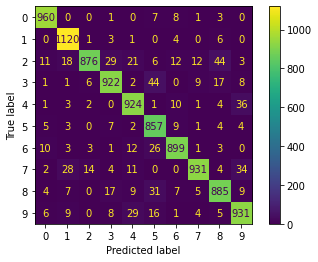

In [ ]:
plot_confusion_matrix(net5, X_test, y_test)

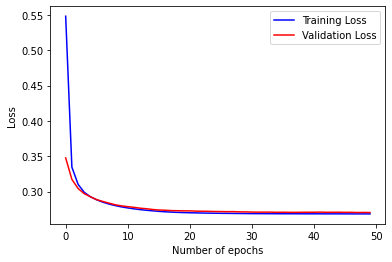

In [ ]:
plt.plot(net5.history[:,"train_loss"], label="Training Loss", color='b')
plt.plot(net5.history[:,"valid_loss"], label="Validation Loss", color='r')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

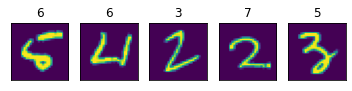

In [ ]:
# Observing misclassified images
misclassified_imgs = y_pred5 != y_test
plot_example(X_test[misclassified_imgs], y_pred5[misclassified_imgs])

In [ ]:
# Save model using pickle
with open("MLP_trained.pkl", "wb") as f:
  pickle.dump(net5, f)